In [1]:
#Libraries we will need.
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import librosa.display
from tqdm import tqdm
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras.models as models
import tensorflow.keras.layers as layers
import IPython.display as ipd
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%matplotlib inline
%load_ext tensorboard

2021-12-21 16:09:34.060353: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [2]:
audio = "../input/gtzan-dataset-music-genre-classification/Data/genres_original/blues/blues.00000.wav"
x,y = librosa.load(audio)
sr=y

In [3]:
print(x.shape)
print(type(x))
print(y)
print(type(y))

(661794,)
<class 'numpy.ndarray'>
22050
<class 'int'>


In [4]:
import IPython.display as ipd
ipd.Audio(audio)

<Figure size 720x216 with 0 Axes>

Text(0.5, 1.0, 'Blues Song 1')

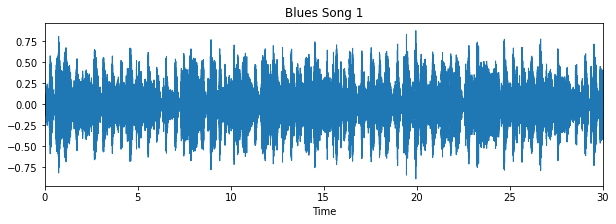

In [5]:
import matplotlib.pyplot as plt
import librosa.display
plt.figure(figsize=(10,3))
plt.title("Blues Song 1")
librosa.display.waveplot(x,sr=y)

<Figure size 1440x576 with 0 Axes>

Text(0.5, 1.0, 'Spectogram')

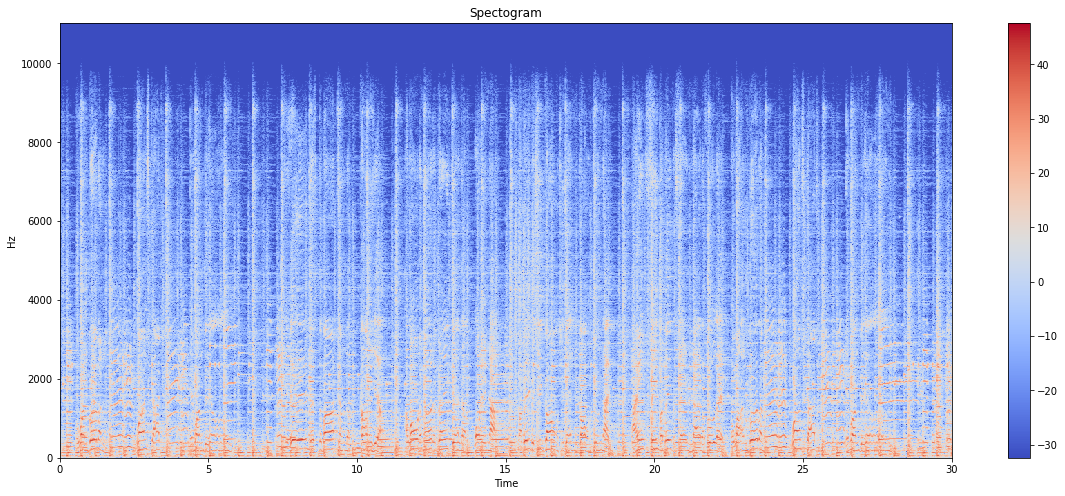

In [6]:
X=librosa.stft(x)
X_db=librosa.amplitude_to_db(abs(X)) #Translation from amplitude to desibel(db) value
plt.figure(figsize=(20,8))
librosa.display.specshow(X_db, sr=sr,x_axis="time",y_axis="hz")
plt.title("Spectogram")
plt.colorbar()

In [7]:
sample3 = r"../input/gtzan-dataset-music-genre-classification/Data/genres_original/jazz/jazz.00005.wav"
x,sr = librosa.load(sample3)
ipd.Audio(x,rate=sr) 

In [8]:
data_h, data_p = librosa.effects.hpss(x)
spec_h = librosa.feature.melspectrogram(data_h, sr=sr)
spec_p = librosa.feature.melspectrogram(data_p, sr=sr)
db_spec_h = librosa.power_to_db(spec_h,ref=np.max)
db_spec_p = librosa.power_to_db(spec_p,ref=np.max)

In [9]:
ipd.Audio(data_h,rate=sr) 

Text(0.5, 1.0, 'Harmonic Mel Spectogram')

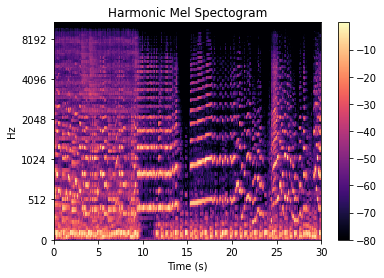

In [10]:
librosa.display.specshow(db_spec_h,y_axis='mel', x_axis='s', sr=sr)
plt.title("Harmonic Mel Spectogram")
plt.colorbar()

In [11]:
ipd.Audio(data_p,rate=sr) 

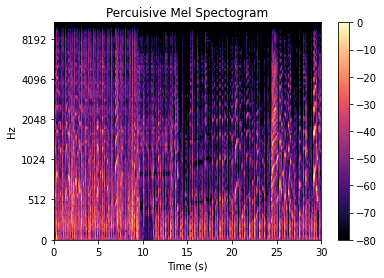

In [12]:
librosa.display.specshow(db_spec_p,y_axis='mel', x_axis='s', sr=sr)
plt.title("Percuisive Mel Spectogram")
plt.colorbar();

*harmonic and precusive mel specograms*

#### Chroma Feature
It gives a relation between pitches. 


<Figure size 720x288 with 0 Axes>

Text(0.5, 1.0, 'Chromagram')

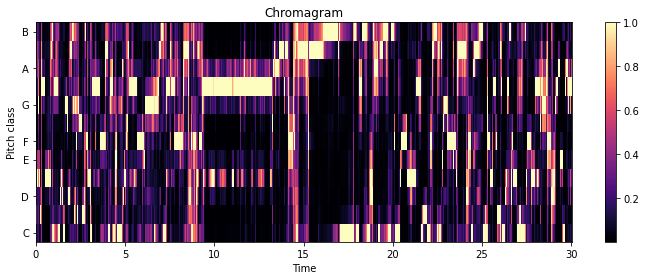

In [13]:
y, sr = librosa.load(sample3)
chroma=librosa.feature.chroma_stft(y=y, sr=sr)
plt.figure(figsize=(10, 4))
librosa.display.specshow(chroma, y_axis='chroma', x_axis='time')
plt.colorbar()
plt.title('Chromagram')
plt.tight_layout()

#### Spectral Bandwidth

Difference between the upper and lower frequencies in a continuous band of frequencies. 

In [14]:
spec_band=librosa.feature.spectral_bandwidth(x,sr=sr)
print("Spectral Bandwidth Shape: ",spec_band.shape)
print("Spectral Bandwidth: ", spec_band)

Spectral Bandwidth Shape:  (1, 1293)
Spectral Bandwidth:  [[1812.85964685 1733.36849169 1931.09627414 ... 1588.97301613
  1570.82267152 1482.40098518]]


## Using CNNs

In [15]:
csvfile = "../input/gtzan-dataset-music-genre-classification/Data/features_3_sec.csv"  
musicdata = "../input/gtzan-dataset-music-genre-classification/Data/genres_original"

In [16]:
df = pd.read_csv(csvfile)
df.head()
df.shape

filename  length  chroma_stft_mean  chroma_stft_var  rms_mean  \
0  blues.00000.0.wav   66149          0.335406         0.091048  0.130405   
1  blues.00000.1.wav   66149          0.343065         0.086147  0.112699   
2  blues.00000.2.wav   66149          0.346815         0.092243  0.132003   
3  blues.00000.3.wav   66149          0.363639         0.086856  0.132565   
4  blues.00000.4.wav   66149          0.335579         0.088129  0.143289   

    rms_var  spectral_centroid_mean  spectral_centroid_var  \
0  0.003521             1773.065032          167541.630869   
1  0.001450             1816.693777           90525.690866   
2  0.004620             1788.539719          111407.437613   
3  0.002448             1655.289045          111952.284517   
4  0.001701             1630.656199           79667.267654   

   spectral_bandwidth_mean  spectral_bandwidth_var  ...  mfcc16_var  \
0              1972.744388           117335.771563  ...   39.687145   
1              2010.051501            65671.875673  ...   64.748276   
2              2084.565132            75124.921716  ...   67.336563   
3              1960.039988            82913.639269  ...   47.739452   
4              1948.503884            60204.020268  ...   30.336359   

   mfcc17_mean  mfcc17_var  mfcc18_mean  mfcc18_var  mfcc19_mean  mfcc19_var  \
0    -3.241280   36.488243     0.722209   38.099152    -5.050335   33.618073   
1    -6.055294   40.677654     0.159015   51.264091    -2.837699   97.030830   
2    -1.768610   28.348579     2.378768   45.717648    -1.938424   53.050835   
3    -3.841155   28.337118     1.218588   34.770935    -3.580352   50.836224   
4     0.664582   45.880913     1.689446   51.363583    -3.392489   26.738789   

   mfcc20_mean  mfcc20_var  label  
0    -0.243027   43.771767  blues  
1     5.784063   59.943081  blues  
2     2.517375   33.105122  blues  
3     3.630866   32.023678  blues  
4     0.536961   29.146694  blues  

[5 rows x 60 columns]

(9990, 60)

modifying the data 

In [17]:
classes = df['label'].unique()
print("Classes are: ",classes)
print("# of Classes are: ",classes.shape[0])

Classes are:  ['blues' 'classical' 'country' 'disco' 'hiphop' 'jazz' 'metal' 'pop'
 'reggae' 'rock']
# of Classes are:  10


In [18]:
class_dict = {i:x for x,i in enumerate(classes)}


In [19]:

df = df.drop_duplicates(subset=['filename'])

In [20]:
df['target'] = df['label'].map(class_dict)
df.head()
print("df shape: ", df.shape)

filename  length  chroma_stft_mean  chroma_stft_var  rms_mean  \
0  blues.00000.0.wav   66149          0.335406         0.091048  0.130405   
1  blues.00000.1.wav   66149          0.343065         0.086147  0.112699   
2  blues.00000.2.wav   66149          0.346815         0.092243  0.132003   
3  blues.00000.3.wav   66149          0.363639         0.086856  0.132565   
4  blues.00000.4.wav   66149          0.335579         0.088129  0.143289   

    rms_var  spectral_centroid_mean  spectral_centroid_var  \
0  0.003521             1773.065032          167541.630869   
1  0.001450             1816.693777           90525.690866   
2  0.004620             1788.539719          111407.437613   
3  0.002448             1655.289045          111952.284517   
4  0.001701             1630.656199           79667.267654   

   spectral_bandwidth_mean  spectral_bandwidth_var  ...  mfcc17_mean  \
0              1972.744388           117335.771563  ...    -3.241280   
1              2010.051501            65671.875673  ...    -6.055294   
2              2084.565132            75124.921716  ...    -1.768610   
3              1960.039988            82913.639269  ...    -3.841155   
4              1948.503884            60204.020268  ...     0.664582   

   mfcc17_var  mfcc18_mean  mfcc18_var  mfcc19_mean  mfcc19_var  mfcc20_mean  \
0   36.488243     0.722209   38.099152    -5.050335   33.618073    -0.243027   
1   40.677654     0.159015   51.264091    -2.837699   97.030830     5.784063   
2   28.348579     2.378768   45.717648    -1.938424   53.050835     2.517375   
3   28.337118     1.218588   34.770935    -3.580352   50.836224     3.630866   
4   45.880913     1.689446   51.363583    -3.392489   26.738789     0.536961   

   mfcc20_var  label  target  
0   43.771767  blues       0  
1   59.943081  blues       0  
2   33.105122  blues       0  
3   32.023678  blues       0  
4   29.146694  blues       0  

[5 rows x 61 columns]

df shape:  (9990, 61)


In [21]:
X = []
y = []

* (mfcc=40) as sampling and prepering the input.
